In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from olympus import __home__
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.campaigns import Campaign 
from olympus.planners import Planner
from olympus.scalarizers import Scalarizer

```{
        "constraints": {
                        "parameters": "none",
                        "measurements": "positive"
                },
        "parameters": [
                        {"name": "drug_input", "type": "continuous", "low": 6.0,  "high": 48.0},
                        {"name": "solid_lipid", "type": "categorical", "options": ["Stearic_acid", "Compritol_888", "Glyceryl_monostearate"], "descriptors": []},
                        {"name": "solid_lipid_input", "type": "continuous", "low": 72.0,  "high": 120.0},
                        {"name": "liquid_lipid_input", "type": "continuous", "low": 0.0,  "high": 48.0},
                        {"name": "surfractant_input", "type": "continuous", "low": 0.0,  "high": 0.01}
                ],
        "measurements": [
                {"name": "drug_loading", "type": "continuous"},
                {"name": "encap_efficiency", "type": "continuous"},
                {"name": "particle_diameter", "type": "continuous"}
        ],
    "default_goal": ["minimize", "maximize", "maximize"] ```

In [65]:
param_names = ['drug_input', 'solid_lipid', 'solid_lipid_input', 'liquid_lipid_input', 'surfractant_input']
obj_names = ['drug_loading', 'encap_efficiency', 'particle_diameter']

gt_df = pd.read_csv(f'{__home__}/datasets/dataset_lnp3/data.csv', 
                   names=param_names+obj_names)

for name in param_names:
    print(gt_df[name].unique())
    
gt_df.head()

[ 6 12 24 48]
['Stearic_acid' 'Compritol_888' 'Glyceryl_monostearate']
[120 108  96  72]
[ 0 12 24 48]
[0.     0.0025 0.005  0.01  ]


,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter
0,6,Stearic_acid,120,0,0.0,0.001985,0.039774,2.717825
1,12,Stearic_acid,120,0,0.0,0.005693,0.057255,2.754903
2,24,Stearic_acid,120,0,0.0,0.012296,0.062258,3.085163
3,48,Stearic_acid,120,0,0.0,0.070099,0.188517,1.788566
4,6,Stearic_acid,108,12,0.0,0.001675,0.033558,2.596390


In [63]:
# define the space

drug_input = [6., 12., 24., 48.]
solid_lipid = ['Stearic_acid', 'Compritol_888', 'Glyceryl_monostearate']
solid_lipid_input = [120., 108.,  96.,  72.,]
liquid_liquid_input = [0., 12., 24., 48]
surfractant_input = [0., 0.0025, 0.005, 0.01]

cart_product = list(itertools.product(*[
    drug_input, solid_lipid, solid_lipid_input, liquid_liquid_input, surfractant_input,
]))
len(cart_product)

768

In [82]:
# construct hybrid dataset
# values = {'drug_input': [], 'solid_lipid': [], 'solid_lipid_input': [], 
#          'liquid_liquid_input': [], 'surfractant_input': [], 'drug_loading': [], 
#          'encap_efficiency': [], 'particle_diameter': [], 'type': []}

# load emulator 
em = Emulator(dataset='lnp3', model='BayesNeuralNet')

values = []

for params in cart_product:
    match = gt_df[
                (gt_df['drug_input']==int(params[0]))&\
                (gt_df['solid_lipid']==params[1])&\
                (gt_df['solid_lipid_input']==int(params[2]))&\
                (gt_df['liquid_lipid_input']==int(params[3]))&\
                (gt_df['surfractant_input']==params[4])
            ].to_dict('r')
    if len(match)==1:
        # have ground truth measurement
        match = match[0]
        match['type'] = 'ground_truth'
        values.append(match)
        
    elif len(match)==0:
        # need virtual measurement
        meas = em.run(list(params), num_samples=100)
        value = {
            'drug_input': int(params[0]),
            'solid_lipid': params[1],
            'solid_lipid_input': int(params[2]),
            'liquid_lipid_input': int(params[3]),
            'surfractant_input': params[4],
            'drug_loading': meas[0][0],
            'encap_efficiency': meas[0][1],
            'particle_diameter': meas[0][2],
            'type': 'virtual',
        }
        values.append(value)
        
    
    
full_df = pd.DataFrame(values)
print(full_df.shape)
full_df.head()

[INFO] Loading emulator using a BayesNeuralNet model for the dataset lnp3...


/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.


(768, 9)


,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter,type
0,6,Stearic_acid,120,0,0.0000,0.001985,0.039774,2.717825,ground_truth
1,6,Stearic_acid,120,0,0.0025,0.005561,0.111845,3.259465,ground_truth
2,6,Stearic_acid,120,0,0.0050,0.010756,0.193019,3.601795,virtual
3,6,Stearic_acid,120,0,0.0100,0.008403,0.194115,3.635673,virtual
4,6,Stearic_acid,120,12,0.0000,0.001873,0.038852,2.559294,virtual


In [84]:
data_only_df = full_df.drop('type', axis=1)


In [85]:
data_only_df.head()

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter
0,6,Stearic_acid,120,0,0.0000,0.001985,0.039774,2.717825
1,6,Stearic_acid,120,0,0.0025,0.005561,0.111845,3.259465
2,6,Stearic_acid,120,0,0.0050,0.010756,0.193019,3.601795
3,6,Stearic_acid,120,0,0.0100,0.008403,0.194115,3.635673
4,6,Stearic_acid,120,12,0.0000,0.001873,0.038852,2.559294


In [131]:
data_only_df.astype({'drug_input': str, 'solid_lipid_input': str, 'liquid_lipid_input': str, 
                    'surfractant_input': str})

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter
0,6,Stearic_acid,120,0,0.0,0.001985,0.039774,2.717825
1,6,Stearic_acid,120,0,0.0025,0.005561,0.111845,3.259465
2,6,Stearic_acid,120,0,0.005,0.010756,0.193019,3.601795
3,6,Stearic_acid,120,0,0.01,0.008403,0.194115,3.635673
4,6,Stearic_acid,120,12,0.0,0.001873,0.038852,2.559294
...,...,...,...,...,...,...,...,...
763,48,Glyceryl_monostearate,72,24,0.01,0.082024,0.413204,3.566627
764,48,Glyceryl_monostearate,72,48,0.0,0.077911,0.211392,2.057659
765,48,Glyceryl_monostearate,72,48,0.0025,0.085419,0.233575,0.937405
766,48,Glyceryl_monostearate,72,48,0.005,0.092633,0.353034,2.398512


In [132]:
data_only_df.to_csv(f'{__home__}/datasets/dataset_lnp3/data.csv', index=False)


In [140]:
df_virt = full_df[full_df['type']=='virtual']
df_gt = full_df[full_df['type']=='ground_truth']

/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

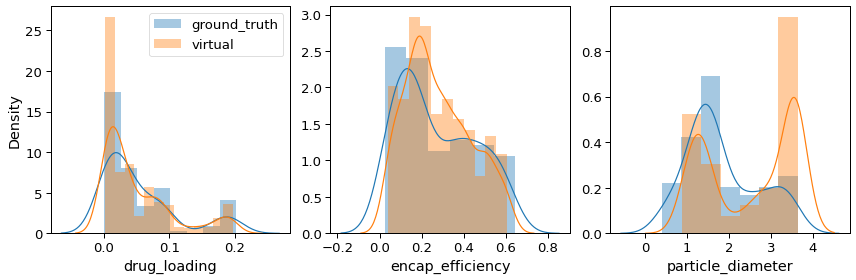

In [148]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.distplot(df_gt['drug_loading'], label='ground_truth', ax=axes[0])
sns.distplot(df_virt['drug_loading'], label='virtual', ax=axes[0])

sns.distplot(df_gt['encap_efficiency'], label='ground_truth', ax=axes[1])
sns.distplot(df_virt['encap_efficiency'], label='virtual', ax=axes[1])

sns.distplot(df_gt['particle_diameter'], label='ground_truth', ax=axes[2])
sns.distplot(df_virt['particle_diameter'], label='virtual', ax=axes[2])

axes[0].legend(loc='upper right')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

plt.tight_layout()

In [154]:
print('max drug_loading : ', full_df.drug_loading.max())
print('max encap_efficiency : ', full_df.encap_efficiency.max())
print('min |300nm-particle_diameter| : ', full_df.particle_diameter.min())

max drug_loading :  0.2018981967587141
max encap_efficiency :  0.6464171735334162
min |300nm-particle_diameter| :  0.3971169650589185


In [156]:
params = full_df[param_names].values
values = full_df[obj_names].values

In [161]:
scalarizer = Scalarizer(kind='Hypervolume', value_space=dataset.value_space, goals=['max', 'max', 'min'])
scalarized = scalarizer.scalarize(values)

idx = np.argsort(scalarized)
sort_params = params[idx]
sort_values = values[idx]
sort_scalarized = scalarized[idx]

In [159]:
sort_params[:10]

array([[48, 'Compritol_888', 120, 0, 0.005],
       [48, 'Compritol_888', 96, 24, 0.005],
       [48, 'Compritol_888', 108, 12, 0.005],
       [48, 'Compritol_888', 72, 48, 0.0025],
       [48, 'Compritol_888', 72, 24, 0.005],
       [48, 'Compritol_888', 72, 0, 0.005],
       [48, 'Compritol_888', 72, 12, 0.005],
       [48, 'Compritol_888', 96, 48, 0.005],
       [48, 'Compritol_888', 108, 24, 0.005],
       [48, 'Compritol_888', 96, 12, 0.005]], dtype=object)

In [160]:
sort_values[:10]

array([[0.19653612, 0.61154421, 1.06954354],
       [0.19114267, 0.59118107, 1.0225136 ],
       [0.19680698, 0.6127145 , 1.27565067],
       [0.18125571, 0.55354965, 0.80002707],
       [0.19295693, 0.60088858, 1.29689585],
       [0.1924296 , 0.60105062, 1.29450586],
       [0.19277053, 0.60101346, 1.29925058],
       [0.19185061, 0.59848347, 1.29151627],
       [0.19047817, 0.5955666 , 1.27104549],
       [0.19139277, 0.59575911, 1.28429316]])

In [162]:
sort_scalarized[:10]

array([0.        , 0.04416903, 0.0769648 , 0.08224301, 0.12126957,
       0.12254714, 0.12281484, 0.1279881 , 0.13116533, 0.13154961])